In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from helpers.collection_of_experiments import CollectionOfExperiments
from helpers.plot_helpers import *
from helpers.computational_tools import remesh, select_LatLon, Lk_error, x_coord, y_coord, gaussian_remesh
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cmocean
import os
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings("ignore")
import hvplot.xarray
import hvplot
hvplot.output(widget_location='bottom')

In [3]:
ds = CollectionOfExperiments.init_folder('/scratch/pp2681/mom6/Feb2022/bare', additional_subfolder='output')

In [4]:
directory = "/scratch/pp2681/mom6/Apr2023/R4-sensitivity"
for name in os.listdir(directory):
    ds += CollectionOfExperiments.init_folder(os.path.join(directory,name), additional_subfolder='output', prefix=name)

In [5]:
directory = "/scratch/pp2681/mom6/Apr2023/R4-selected"
for name in os.listdir(directory):
    ds += CollectionOfExperiments.init_folder(os.path.join(directory,name), additional_subfolder='output', prefix=name)

In [6]:
directory = "/scratch/pp2681/mom6/Apr2023/generalization"
for name in os.listdir(directory):
    ds += CollectionOfExperiments.init_folder(os.path.join(directory,name), additional_subfolder='output', prefix=name)

In [7]:
ds += CollectionOfExperiments.init_folder('/scratch/pp2681/mom6/Apr2023/GZ21_results', additional_subfolder='')

In [8]:
len(ds.exps)

1088

In [9]:
for exp in ds.exps:
    if 'GZ' in exp:
        print(exp)

GZ21-R4
GZ21-R5
GZ21-R6
GZ21-R7
GZ21-R8
R2_GZ-20YEAR_no_scaling
R3_GZ-20YEAR_no_scaling
R4_GZ-20YEAR
R4_GZ-20YEAR_no_scaling
R5_GZ-20YEAR
R5_GZ-20YEAR_no_scaling
R6_GZ-20YEAR
R6_GZ-20YEAR_no_scaling
R7_GZ-20YEAR
R7_GZ-20YEAR_no_scaling
R8_GZ-20YEAR
R8_GZ-20YEAR_no_scaling


In [10]:
for exp in ['R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'R8']:
    ds.remesh('R64', exp)

Experiment R64 coarsegrained to R2 is created. Its identificator=R64_R2
Experiment R64 coarsegrained to R3 is created. Its identificator=R64_R3
Experiment R64 coarsegrained to R4 is created. Its identificator=R64_R4
Experiment R64 coarsegrained to R5 is created. Its identificator=R64_R5
Experiment R64 coarsegrained to R6 is created. Its identificator=R64_R6
Experiment R64 coarsegrained to R7 is created. Its identificator=R64_R7
Experiment R64 coarsegrained to R8 is created. Its identificator=R64_R8


# Visual analysis

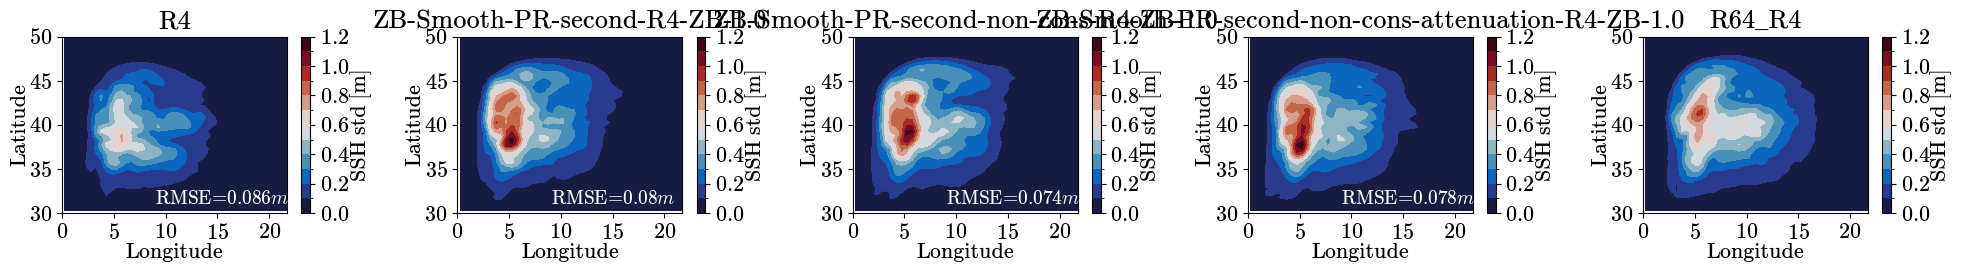

In [55]:
RR = 'R4'
ds.plot_ssh_std([RR, f'ZB-Smooth-PR-second-{RR}-ZB-1.0', f'ZB-Smooth-PR-second-non-cons-{RR}-ZB-1.0', 
            f'ZB-Smooth-PR-second-non-cons-attenuation-{RR}-ZB-1.0', f'R64_{RR}'])

# Generalization

In [11]:
def sample_ssh(exp, target):
    
    sample = []
    for year_start in [5, 10, 15]:
        year_end = year_start + 5
        idx = slice(365*year_start, 365*year_end)
        sample.append(
            Lk_error(ds[exp].ea.isel(zi=0).sel(Time=idx).mean('Time'), ds[target].ssh_mean)[0]
        )
    return xr.DataArray(sample, dims='sample')

In [12]:
def error_ssh(exp, target):
    return Lk_error(ds[exp].ssh_mean,ds[target].ssh_mean)[0]

In [13]:
def sample_KE(exp, target=None):
    sample = []
    for year_start in [5, 10, 15]:
        year_end = year_start + 5
        idx = slice(365*year_start, 365*year_end)
        u = ds[exp].u.sel(Time=idx)
        v = ds[exp].v.sel(Time=idx)
        h = ds[exp].h.sel(Time=idx)

        KE = 1e-15 * ds[exp].KE_joul(u, v, h).mean('Time').sum()
        #print(year_start)
        #print(KE.compute())
        sample.append(KE)
    return xr.DataArray(sample, dims='sample')

In [14]:
def KE(exp, target=None):
    return 1e-15 * (ds[exp].MKE_joul + ds[exp].EKE_joul).sum('zl').values

In [15]:
def sample_APE(exp, target=None):
    sample = []
    for year_start in [5, 10, 15]:
        year_end = year_start + 5
        idx = slice(365*year_start, 365*year_end)
        e = ds[exp].e.sel(Time=idx)
        APE = 1e-15 * (
            ds[exp].PE_joul(e).mean('Time').sum() + 
            ds[exp].PE_ssh(e).mean('Time').sum()
        )
        sample.append(APE)
    return xr.DataArray(sample, dims='sample')

In [16]:
def APE(exp, target=None):
    return 1e-15 * (ds[exp].MPE_joul + ds[exp].EPE_joul + ds[exp].MPE_ssh + ds[exp].EPE_ssh).values

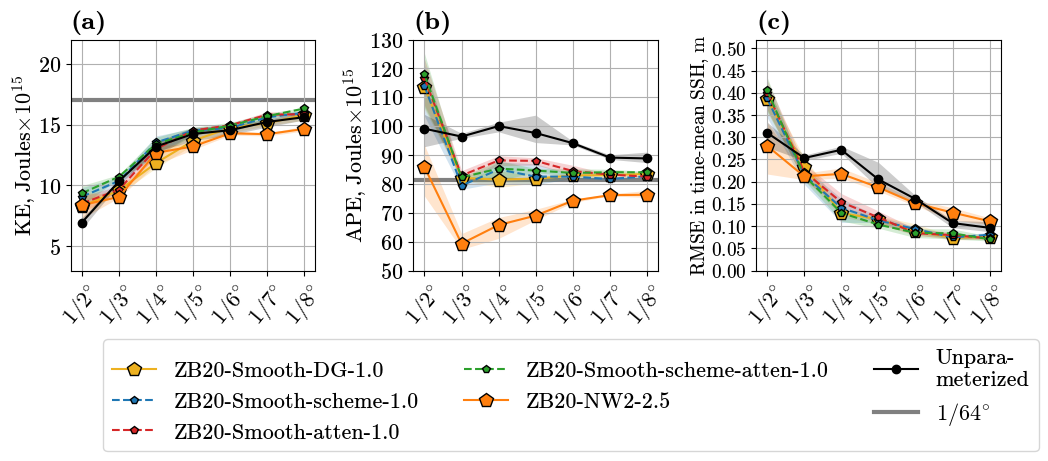

In [25]:
default_rcParams({'font.size': 16, 'figure.subplot.wspace': 0.4, 'figure.subplot.hspace': 0.1})
plt.figure(figsize=(12,3))

yellow = [0.9290, 0.6940, 0.1250]
violet = [0.4940, 0.1840, 0.5560]
lightblue = [0.3010, 0.7450, 0.9330]

for row, fun in enumerate([sample_KE, sample_APE, sample_ssh]):
    plt.subplot(1,3,row+1)
    error = {}
    error['bare'] = xr.concat([fun(conf,f'R64_{conf}') for conf in ['R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'R8']], dim='res')
    #error['ZB-clean'] = xr.concat([fun(f'ZB-clean-{conf}-ZB-0.4', f'R64_{conf}') for conf in ['R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'R8']], dim='res')
    #error['ZB-Smooth'] = xr.concat([fun(f'ZB-Smooth-{conf}-ZB-1.0', f'R64_{conf}') for conf in ['R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'R8']], dim='res')
    error['ZB-Smooth-PR2'] = xr.concat([fun(f'ZB-Smooth-PR-second-{conf}-ZB-1.0', f'R64_{conf}') for conf in ['R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'R8']], dim='res')
    error['ZB-Smooth-non-cons'] = xr.concat([fun(f'ZB-Smooth-PR-second-non-cons-{conf}-ZB-1.0', f'R64_{conf}') for conf in ['R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'R8']], dim='res')
    error['ZB-Smooth-attenuation'] = xr.concat([fun(f'ZB-Smooth-PR-second-attenuation-{conf}-ZB-1.0', f'R64_{conf}') for conf in ['R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'R8']], dim='res')
    error['ZB-Smooth-non-cons-attenuation'] = xr.concat([fun(f'ZB-Smooth-PR-second-non-cons-attenuation-{conf}-ZB-1.0', f'R64_{conf}') for conf in ['R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'R8']], dim='res')
    error['ZB-Smooth-NW2'] = xr.concat([fun(f'ZB-Smooth-PR-second-NW2-{conf}-ZB-2.5', f'R64_{conf}') for conf in ['R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'R8']], dim='res')
    #error['ZB-Reynolds'] = xr.concat([fun(f'ZB-Reynolds-{conf}-ZB-2.0', f'R64_{conf}') for conf in ['R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'R8']], dim='res')
    #error['ZB-Reynolds-NW2'] = xr.concat([fun(f'ZB-Reynolds-PR-second-NW2-{conf}-ZB-2.5', f'R64_{conf}') for conf in ['R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'R8']], dim='res')
#    error['Jansen-Held'] = xr.concat([fun(f'Jansen-Held-{conf}-ref', f'R64_{conf}') for conf in ['R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'R8']], dim='res')
#    error['GZ'] = xr.concat([error['bare'].isel(res=0)*np.nan, error['bare'].isel(res=0)*np.nan] + [fun(f'{conf}_GZ-20YEAR', f'R64_{conf}') for conf in ['R4', 'R5', 'R6', 'R7', 'R8']], dim='res')
    
    def plot_markers_with_filling(model='Jansen-Held', color='tab:red', marker='s', label=None, markersize=None, ls='-'):
        error[model].mean('sample').plot(color=color, marker=marker, label=label, markersize=markersize, markeredgecolor='k', ls=ls)
        plt.fill_between(range(7), error[model].min('sample'), error[model].max('sample'), color=color, alpha=0.2, lw=0)
    
#    plot_markers_with_filling('Jansen-Held', 'tab:red', 's', 'JHAH15', 5)
#    plot_markers_with_filling('GZ', 'tab:green', 'D', 'GZ21', 5)
    #plot_markers_with_filling('ZB-clean', 'tab:blue', 'o', 'ZB')
#    plot_markers_with_filling('ZB-Smooth', yellow, 'p', 'ZB20-Smooth', 7)
    plot_markers_with_filling('ZB-Smooth-PR2', yellow, 'p', 'ZB20-Smooth-DG-1.0', 10, ls='-')
    plot_markers_with_filling('ZB-Smooth-non-cons', 'tab:blue', 'p', 'ZB20-Smooth-scheme-1.0', 6, ls='--')
    plot_markers_with_filling('ZB-Smooth-attenuation', 'tab:red', 'p', 'ZB20-Smooth-atten-1.0', 6, ls='--')
    plot_markers_with_filling('ZB-Smooth-non-cons-attenuation', 'tab:green', 'p', 'ZB20-Smooth-scheme-atten-1.0', 6, ls='--')
    plot_markers_with_filling('ZB-Smooth-NW2', 'tab:orange', 'p', 'ZB20-NW2-2.5', 10, ls='-')
#    plot_markers_with_filling('ZB-Reynolds', violet, 'd', 'ZB20-Reynolds-DG', 6)
#    plot_markers_with_filling('ZB-Reynolds-NW2', 'tab:pink', 'd', 'ZB20-Reynolds-NW2', 6)
    plot_markers_with_filling('bare', 'k', 'o', 'Unpara-\nmeterized', 6)
    
    plt.xticks([0,1,2,3,4,5,6], ['$1/2^{\circ}$', '$1/3^{\circ}$', '$1/4^{\circ}$', '$1/5^{\circ}$', '$1/6^{\circ}$', '$1/7^{\circ}$', '$1/8^{\circ}$'],rotation=50)    
    plt.grid()
    plt.xlabel('')
    if fun == sample_KE:
        yticks = np.arange(5,25,5)
        plt.ylabel('KE, Joules$\\times10^{15}$')
        plt.yticks(yticks)
        plt.ylim([3,22])
        plt.axhline(y=KE('R64'),color='gray', zorder=-1,lw=3)
        #plt.text(0.0, 17.5,'$1/64^o$', color='gray')
    if fun == sample_APE:
        yticks = np.arange(50,140,10)
        plt.ylabel('APE, Joules$\\times10^{15}$')
        plt.yticks(yticks)
        plt.ylim([min(yticks), max(yticks)])
        plt.axhline(y=APE('R64'),color='gray',zorder=-1,lw=3)
    
    if fun == sample_ssh:
        yticks = np.arange(0,0.55,0.05)
        plt.ylabel('RMSE in time-mean SSH, $\mathrm{m}$', fontsize=14)
        plt.yticks(yticks, fontsize=14)
        plt.ylim([0,0.52])

plt.gcf().align_ylabels()
set_letters(fontsize=18,x=0.0,y=1.05)
plt.plot(np.nan,np.nan,'-',color='gray',lw=3,label='$1/64^{\circ}$')
plt.legend(ncol=3, bbox_to_anchor=(1.2,-0.25))

plt.savefig('DG-NW2-sensitivity/Double-Gyre-vs-NW2-Smooth.pdf')

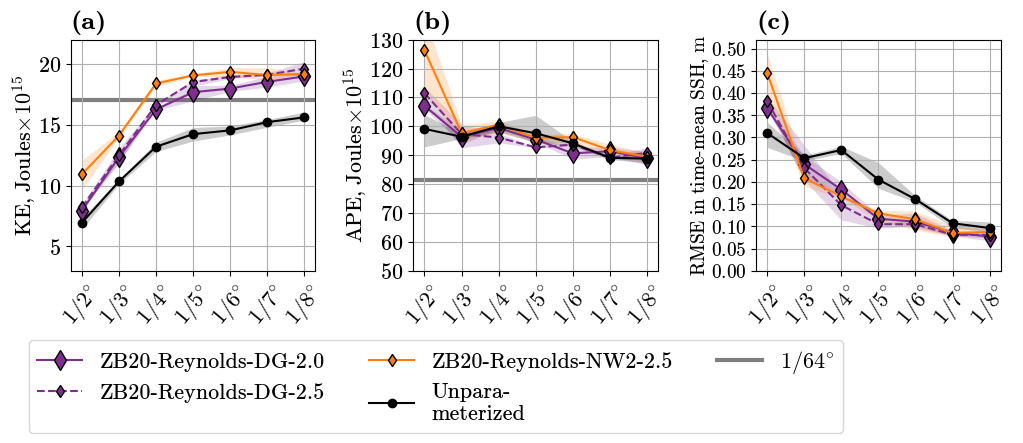

In [22]:
default_rcParams({'font.size': 16, 'figure.subplot.wspace': 0.4, 'figure.subplot.hspace': 0.1})
plt.figure(figsize=(12,3))

yellow = [0.9290, 0.6940, 0.1250]
violet = [0.4940, 0.1840, 0.5560]
lightblue = [0.3010, 0.7450, 0.9330]

for row, fun in enumerate([sample_KE, sample_APE, sample_ssh]):
    plt.subplot(1,3,row+1)
    error = {}
    error['bare'] = xr.concat([fun(conf,f'R64_{conf}') for conf in ['R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'R8']], dim='res')
    error['ZB-Reynolds'] = xr.concat([fun(f'ZB-Reynolds-{conf}-ZB-2.0', f'R64_{conf}') for conf in ['R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'R8']], dim='res')
    error['ZB-Reynolds-2.5'] = xr.concat([fun(f'ZB-Reynolds-{conf}-ZB-2.5', f'R64_{conf}') for conf in ['R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'R8']], dim='res')
    error['ZB-Reynolds-NW2'] = xr.concat([fun(f'ZB-Reynolds-PR-second-NW2-{conf}-ZB-2.5', f'R64_{conf}') for conf in ['R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'R8']], dim='res')
#    error['Jansen-Held'] = xr.concat([fun(f'Jansen-Held-{conf}-ref', f'R64_{conf}') for conf in ['R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'R8']], dim='res')
#    error['GZ'] = xr.concat([error['bare'].isel(res=0)*np.nan, error['bare'].isel(res=0)*np.nan] + [fun(f'{conf}_GZ-20YEAR', f'R64_{conf}') for conf in ['R4', 'R5', 'R6', 'R7', 'R8']], dim='res')
    
    def plot_markers_with_filling(model='Jansen-Held', color='tab:red', marker='s', label=None, markersize=None, ls='-'):
        error[model].mean('sample').plot(color=color, marker=marker, label=label, markersize=markersize, markeredgecolor='k', ls=ls)
        plt.fill_between(range(7), error[model].min('sample'), error[model].max('sample'), color=color, alpha=0.2, lw=0)
    
#    plot_markers_with_filling('Jansen-Held', 'tab:red', 's', 'JHAH15', 5)
#    plot_markers_with_filling('GZ', 'tab:green', 'D', 'GZ21', 5)
    #plot_markers_with_filling('ZB-clean', 'tab:blue', 'o', 'ZB')
#    plot_markers_with_filling('ZB-Smooth', yellow, 'p', 'ZB20-Smooth', 7)
#     plot_markers_with_filling('ZB-Smooth-PR2', yellow, 'p', 'ZB20-Smooth-DG', 10, ls='-')
#     plot_markers_with_filling('ZB-Smooth-non-cons', 'tab:blue', 'p', 'ZB20-Smooth-scheme', 6, ls='--')
#     plot_markers_with_filling('ZB-Smooth-attenuation', 'tab:red', 'p', 'ZB20-Smooth-atten', 6, ls='--')
#     plot_markers_with_filling('ZB-Smooth-non-cons-attenuation', 'tab:green', 'p', 'ZB20-Smooth-scheme-atten', 6, ls='--')
#     plot_markers_with_filling('ZB-Smooth-NW2', 'tab:orange', 'p', 'ZB20-NW2', 10, ls='-')
    plot_markers_with_filling('ZB-Reynolds', violet, 'd', 'ZB20-Reynolds-DG-2.0', 10)
    plot_markers_with_filling('ZB-Reynolds-2.5', violet, 'd', 'ZB20-Reynolds-DG-2.5', 6, ls='--')
    plot_markers_with_filling('ZB-Reynolds-NW2', 'tab:orange', 'd', 'ZB20-Reynolds-NW2-2.5', 6)
    plot_markers_with_filling('bare', 'k', 'o', 'Unpara-\nmeterized', 6)
    
    plt.xticks([0,1,2,3,4,5,6], ['$1/2^{\circ}$', '$1/3^{\circ}$', '$1/4^{\circ}$', '$1/5^{\circ}$', '$1/6^{\circ}$', '$1/7^{\circ}$', '$1/8^{\circ}$'],rotation=50)    
    plt.grid()
    plt.xlabel('')
    if fun == sample_KE:
        yticks = np.arange(5,25,5)
        plt.ylabel('KE, Joules$\\times10^{15}$')
        plt.yticks(yticks)
        plt.ylim([3,22])
        plt.axhline(y=KE('R64'),color='gray', zorder=-1,lw=3)
        #plt.text(0.0, 17.5,'$1/64^o$', color='gray')
    if fun == sample_APE:
        yticks = np.arange(50,140,10)
        plt.ylabel('APE, Joules$\\times10^{15}$')
        plt.yticks(yticks)
        plt.ylim([min(yticks), max(yticks)])
        plt.axhline(y=APE('R64'),color='gray',zorder=-1,lw=3)
    
    if fun == sample_ssh:
        yticks = np.arange(0,0.55,0.05)
        plt.ylabel('RMSE in time-mean SSH, $\mathrm{m}$', fontsize=14)
        plt.yticks(yticks, fontsize=14)
        plt.ylim([0,0.52])

plt.gcf().align_ylabels()
set_letters(fontsize=18,x=0.0,y=1.05)
plt.plot(np.nan,np.nan,'-',color='gray',lw=3,label='$1/64^{\circ}$')
plt.legend(ncol=3, bbox_to_anchor=(0.4,-0.25))

plt.savefig('DG-NW2-sensitivity/Double-Gyre-vs-NW2-Reynolds.pdf')